# Logistic Regression

This logistic regression is based on the Beeler/Daw et al. 2010 paper.
Specifically:

dependent variable: binary choice of port (-1 or 1)

explanatory variables: 
1. the N previous rewards $ r_{t-N:t-1} $
2. the previous choice $c_{t-1}$ to capture a tendency to stay or switch
3. bias variable (1) to capture fixed, overall preference for either port

Note: this model only carries information about ports when it gets a reward. IE -1 = right reward, 1 = left reward, but 0 = no reward (for either side). Should compare models with this information vs. added information about the non-rewarded port choices. 

## 02/19/2017
I just ran the above code on the following data:
    
- `full_9010_02192017.csv`
- `full_8020_02192017.csv`
- `full_7030_02192017.csv`

Which were computed by compiling the following data:
- block range: exactly 50 rewards
- p(choose high Port) >= [p-0.1] where p = p(high Port)

Observations:
1. pseudo-R2 also similar: ~0.64-0.69
2. For (1)  maybe a slight trend that 90-10 had a better model, but not certain. 
3. For each condition, I tried adding in more ports (up to 3) into the past to see if it would help out. For all 3 conditions, decisions for t-N where 2 >= 2 had coefficients = 0. That is, the only non-zero beta for the ports was the most recent one. 

Next step: 


**Figures**

1. Logistic regression performs similarly across different conditions
    - x axis: 90-10,80-20,70-30
    - y axis: F1 score, pseudo-R2
2. Comparing model flexibility across different conditions
    - x axis: number of previous rewards included (i.e. parameters in model)
    - y axis: BIC
    - color: each condition
3. Knowing where the non-rewarded trials are:
    - what if you did the same regression, but instead you know where the non-rewarded trials are?
    - also, compare to adding in previous ports (or rewards in the above scenario) and compare

4. Comparing 'strategies' across conditions
    - train on 90-10, test on 80-20 (and all combinations)

5. Comparing 'strategies' across mice
    - train on one mouse:condition pair, and test on another mouse:condition pair (for the same condition)
    


In [2]:
import sys
sys.path.append('/Users/Sabatini Lab/GitHub/mouse_bandit/data_preprocessing_code')
sys.path.append('/Users/Sabatini Lab/GitHub/mouse_bandit')
import support_functions as sf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import pandas as pd
import scipy as sp
import bandit_preprocessing as bp
import sklearn.linear_model
import sklearn.tree
import statsmodels
%matplotlib inline 

## define function to do logistic regression and some basic evalutions

In [3]:
'''
I compiled the code above into a more compact function so I can cycle through different conditions/mice/etc 
as neccessary
'''

def logreg_and_eval(data,num_rewards=10,test_data=False):
    '''
    Perform Logistic Regression on a pandas dataframe of trials (from feature matrix)
    
    Inputs:
        - data: pandas dataframe of trials (from feature matrix)
    Outputs:
        - logreg: trained logistic regression model (from sklearn)
        - stats:  pandas dataframe with F1, pseudo-R2, and BIC scores from model
        - coeffs: beta coefficients from logreg
    
    '''
    
    from statsmodels.discrete.discrete_model import Logit
    
    port_features = []
    reward_features = []

    #change right port to -1 instead of 0
    for col in data:
        if '_Port' in col:
            data.loc[data[col] == 0,col] = -1
            port_features.append(col)
        elif '_Reward' in col:
            reward_features.append(col)

    #create new feature matrix
    d = data.copy()
    for i in range(len(port_features)):
        d[reward_features[i]] = d[reward_features[i]].values*d[port_features[i]].values
    
    
    #determine the features
    features = reward_features.copy()
    features = features[-1*num_rewards:] #only take the num of rewards specificied in the function
    features.append('1_Port') #append the last decision as a feature
    features.append('Decision') #finally append the decision so we can take it to predict later
    
    #final version of data
    d = d[features].copy() #this now just has the features we want and the decision we want to predict
    
    #do the same thing for the test data if it exists!
    if test_data is not False:
        for col in test_data:
            if '_Port' in col:
                test_data.loc[test_data[col] == 0,col] = -1

        #create new feature matrix
        data_test_new = test_data.copy()
        for i in range(len(port_features)):
            data_test_new[reward_features[i]] = test_data[reward_features[i]].values*test_data[port_features[i]].values
        
        d_test = data_test_new[features].copy()
    
    
        #set training and testing sets now
        x_train = d.iloc[:,:-1].values
        y_train = d.iloc[:,-1].values
        x_test = d_test.iloc[:,:-1].values
        y_test = d_test.iloc[:,-1].values
        
        prev_port_test = d_test['1_Port'].values
        prev_port_test[prev_port_test==-1] = 0
    
    #if there is no test data, then split up the data into training and testing
    else:
        #extract features and decisions
        x = d.iloc[:,:-1].values
        y = d.iloc[:,-1].values

        #split into training and testing
        n_trials = x.shape[0]
        shuf_inds = np.random.permutation(n_trials)
        split_ind = int(n_trials*0.7)

        x_train = x[shuf_inds[:split_ind],:]
        y_train = y[shuf_inds[:split_ind]]

        x_test = x[shuf_inds[split_ind:],:]
        y_test = y[shuf_inds[split_ind:]]
        
        #extract previous port decision for test set
        #these will be used to calculate switches on the test predictions
        prev_port_test = d['1_Port'].values[shuf_inds[split_ind:]]
        prev_port_test[prev_port_test==-1] = 0
    
    '''
    Modeling
    '''
    
    #fit logistic regression
    logreg = sklearn.linear_model.LogisticRegressionCV()
    logreg.fit(x_train,y_train)
    
    #predict on testing set
    y_predict = logreg.predict(x_test)
    y_predict_proba = logreg.predict_proba(x_test)
    
    #model accuracy
    score = logreg.score(x_test,y_test)
    
    #calculating pseudo-R2 and BIC from statsmodel OLS
    model = Logit(y_train,x_train)
    rslt  = model.fit()

    #switches
    y_test_switch = np.abs(y_test - prev_port_test)
    y_predict_switch = np.abs(y_predict - prev_port_test)
    acc_pos,acc_neg,F1=sf.score_both_and_confuse(y_predict_switch,y_test_switch,confusion=False,disp=True)
    
    #extract coefficients
    coefs = logreg.coef_ #retrieve coefs
    coefs = np.append(coefs[0],logreg.intercept_) #add bias coef
    
    #create stats database to return
    d_ = {'pseudo-R2':rslt.prsquared,'stay':acc_pos,'switch':acc_neg,'Accuracy':score,
          'BIC':rslt.bic,'negative loglikelihood':-1*rslt.llf,'F1':F1}
    stats = pd.DataFrame(data=d_,index=[0])
    features = features[:-1]
    features.append('Bias')
    
    coefs = pd.DataFrame(data=coefs.reshape(1,-1),columns=features)
    return logreg,stats,coefs

In [4]:
def logreg_and_eval_withports(data,num_rewards=10,num_ports=1,test_data=False):
    '''
    Perform Logistic Regression on a pandas dataframe of trials (from feature matrix)
    
    Inputs:
        - data: pandas dataframe of trials (from feature matrix)
    Outputs:
        - logreg: trained logistic regression model (from sklearn)
        - stats:  pandas dataframe with F1, pseudo-R2, and BIC scores from model
        - coeffs: beta coefficients from logreg
    
    '''
    
    from statsmodels.discrete.discrete_model import Logit
    
    port_features = []
    reward_features = []

    #change right port to -1 instead of 0
    for col in data:
        if '_Port' in col:
            data.loc[data[col] == 0,col] = -1
            port_features.append(col)
        elif '_Reward' in col:
            reward_features.append(col)

    #create new feature matrix
    d = data.copy()
    for i in range(len(port_features)):
        d[reward_features[i]] = d[reward_features[i]].values*d[port_features[i]].values
    
    
    #determine the features
    features = reward_features.copy()
    if num_rewards == 0:
        features = port_features[-1*num_ports:]
    elif num_ports == 0:
        features = features[-1*num_rewards:] #only take the num of rewards specificied in the function
    else:
        features = features[-1*num_rewards:]
        features = np.append(features,port_features[-1*num_ports:])
    
    print(features)
    features = np.append(features,'Decision') #finally append the decision so we can take it to predict later
    
    
    
    #final version of data
    d = d[features].copy() #this now just has the features we want and the decision we want to predict
    
    #do the same thing for the test data if it exists!
    if test_data is not False:
        for col in test_data:
            if '_Port' in col:
                test_data.loc[test_data[col] == 0,col] = -1

        #create new feature matrix
        data_test_new = test_data.copy()
        for i in range(len(port_features)):
            data_test_new[reward_features[i]] = test_data[reward_features[i]].values*test_data[port_features[i]].values
        
        d_test = data_test_new[features].copy()
    
    
        #set training and testing sets now
        x_train = d.iloc[:,:-1].values
        y_train = d.iloc[:,-1].values
        x_test = d_test.iloc[:,:-1].values
        y_test = d_test.iloc[:,-1].values
        
        prev_port_test = test_data['1_Port'].values
        prev_port_test[prev_port_test==-1] = 0
    
    #if there is no test data, then split up the data into training and testing
    else:
        #extract features and decisions
        x = d.iloc[:,:-1].values
        y = d.iloc[:,-1].values

        #split into training and testing
        n_trials = x.shape[0]
        shuf_inds = np.random.permutation(n_trials)
        split_ind = int(n_trials*0.7)

        x_train = x[shuf_inds[:split_ind],:]
        y_train = y[shuf_inds[:split_ind]]

        x_test = x[shuf_inds[split_ind:],:]
        y_test = y[shuf_inds[split_ind:]]
        
        #extract previous port decision for test set
        #these will be used to calculate switches on the test predictions
        prev_port_test = data['1_Port'].values[shuf_inds[split_ind:]]
        prev_port_test[prev_port_test==-1] = 0
    
    '''
    Modeling
    '''
    
    #fit logistic regression
    logreg = sklearn.linear_model.LogisticRegressionCV()
    logreg.fit(x_train,y_train)
    
    #predict on testing set
    y_predict = logreg.predict(x_test)
    y_predict_proba = logreg.predict_proba(x_test)
    
    #model accuracy
    score = logreg.score(x_test,y_test)
    
    #calculating pseudo-R2 and BIC from statsmodel OLS
    model = Logit(y_train,x_train)
    rslt  = model.fit()

    #switches
    y_test_switch = np.abs(y_test - prev_port_test)
    y_predict_switch = np.abs(y_predict - prev_port_test)
    acc_pos,acc_neg,F1=sf.score_both_and_confuse(y_predict_switch,y_test_switch,confusion=False,disp=True)
    
    #extract coefficients
    coefs = logreg.coef_ #retrieve coefs
    coefs = np.append(coefs[0],logreg.intercept_) #add bias coef
    
    #create stats database to return
    d_ = {'pseudo-R2':rslt.prsquared,'stay':acc_pos,'switch':acc_neg,'Accuracy':score,
          'BIC':rslt.bic,'negative loglikelihood':-1*rslt.llf,'F1':F1}
    stats = pd.DataFrame(data=d_,index=[0])
    features = features[:-1]
    features = np.append(features,'Bias')
    
    coefs = pd.DataFrame(data=coefs.reshape(1,-1),columns=features)
    return logreg,stats,coefs


# Write here

In [5]:
data_90 = pd.read_csv('/Users/Sabatini Lab/GitHub/mouse_bandit/data/mike_data/trial_data/all_9010_high.csv',index_col=0)
#data_90 = pd.read_csv('/Users/Sabatini Lab/GitHub/mouse_bandit/data/processed_data/full_9010_02192017.csv',index_col=0)

datas = [data_90]
models = []

In [6]:
datas

[    Mouse ID      Session ID  Trial  Block Trial  Block Reward  Port Streak  \
 0      SOM42  06142017_SOM42   11.0         11.0           7.0          2.0   
 1      SOM42  06142017_SOM42   12.0         12.0           8.0          3.0   
 2      SOM42  06142017_SOM42   13.0         13.0           9.0          4.0   
 3      SOM42  06142017_SOM42   14.0         14.0          10.0          5.0   
 4      SOM42  06142017_SOM42   15.0         15.0          11.0          6.0   
 5      SOM42  06142017_SOM42   16.0         16.0          12.0          7.0   
 6      SOM42  06142017_SOM42   17.0         17.0          13.0          8.0   
 7      SOM42  06142017_SOM42   18.0         18.0          14.0          9.0   
 8      SOM42  06142017_SOM42   19.0         19.0          15.0         10.0   
 9      SOM42  06142017_SOM42   20.0         20.0          16.0         11.0   
 10     SOM42  06142017_SOM42   21.0         21.0          17.0         12.0   
 11     SOM42  06142017_SOM42   22.0    

In [7]:
for i,d in enumerate(datas):
    
    for j in range(30):
        model_curr,stats_curr,coefs_curr = logreg_and_eval(d,num_rewards=7)
        models.append(models)

        if ((i == 0 and j == 0)):
            stats = stats_curr.copy()
            coefs = coefs_curr.copy()
        else:
            stats = stats.append(stats_curr)
            coefs = coefs.append(coefs_curr)

c = np.zeros(30)+90


stats.insert(0,'Condition',c)
coefs.insert(0,'Condition',c)

Optimization terminated successfully.
         Current function value: 0.313076
         Iterations 7
          Predicted NO  Predicted YES
True NO            0.0            0.0
True YES           0.0            0.0

F1: 0.000

Accuracy on class 0: nan
Accuracy on class 1: nan



C:\Users\Sabatini Lab\Anaconda3\envs\behavior\lib\site-packages\numpy\core\fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Sabatini Lab\Anaconda3\envs\behavior\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Optimization terminated successfully.
         Current function value: 0.311025
         Iterations 7
          Predicted NO  Predicted YES
True NO            1.0            0.0
True YES           0.0            0.0

F1: 0.000

Accuracy on class 0: 1.00
Accuracy on class 1: nan

Optimization terminated successfully.
         Current function value: 0.310077
         Iterations 7
          Predicted NO  Predicted YES
True NO            1.0            0.0
True YES           0.0            0.0

F1: 0.000

Accuracy on class 0: 1.00
Accuracy on class 1: nan

Optimization terminated successfully.
         Current function value: 0.311598
         Iterations 7
          Predicted NO  Predicted YES
True NO            0.0            0.0
True YES           0.0            0.0

F1: 0.000

Accuracy on class 0: nan
Accuracy on class 1: nan

Optimization terminated successfully.
         Current function value: 0.308363
         Iterations 7
          Predicted NO  Predicted YES
True NO            0.

In [8]:
stats

,Condition,Accuracy,BIC,F1,negative loglikelihood,pseudo-R2,stay,switch
0,90.0,0.900567,15552.488642,0,7735.784630,0.548205,NaN,NaN
0,90.0,0.899150,15451.160951,0,7685.120784,0.551142,NaN,1.0
0,90.0,0.897639,15404.295379,0,7661.687998,0.552520,NaN,1.0
0,90.0,0.900661,15479.462659,0,7699.271638,0.550299,NaN,NaN
0,90.0,0.896223,15319.585616,0,7619.333117,0.554993,NaN,NaN
0,90.0,0.896884,15550.545765,0,7734.813191,0.548142,NaN,NaN
0,90.0,0.899339,15563.425258,0,7741.252938,0.547830,NaN,NaN
0,90.0,0.900189,15562.371937,0,7740.726277,0.547812,NaN,NaN
0,90.0,0.898772,15458.624696,0,7688.852657,0.550987,NaN,NaN
0,90.0,0.906043,15833.470518,0,7876.275568,0.539992,NaN,NaN


In [9]:
coefs

,Condition,7_Reward,6_Reward,5_Reward,4_Reward,3_Reward,2_Reward,1_Reward,1_Port,Bias
0,90.0,0.868569,0.608359,0.611786,0.790416,1.204853,1.695804,6.405943,-4.184506,-0.785244
0,90.0,0.753657,0.727288,0.730202,0.773412,1.271965,1.663770,6.361293,-4.145239,-0.840181
0,90.0,0.840667,0.431029,0.820763,0.864295,1.070663,1.848563,6.396945,-4.154137,-0.847972
0,90.0,0.750205,0.606933,0.747629,0.979823,1.018726,1.745885,6.425454,-4.022834,-0.911031
0,90.0,0.817203,0.544136,0.819577,0.800489,1.104456,1.927653,6.347736,-4.126152,-0.873987
0,90.0,0.681941,0.776425,0.855651,0.600801,1.196681,1.821993,6.291030,-3.762865,-0.975596
0,90.0,0.918478,0.595749,0.706547,0.645877,1.189892,1.791535,6.350515,-4.088492,-0.841021
0,90.0,0.733452,0.694560,0.867246,0.827866,1.162312,1.650805,6.341603,-3.826140,-0.968530
0,90.0,0.808238,0.722061,0.787417,0.763540,1.183438,1.766629,6.303078,-4.236988,-0.837806
0,90.0,0.721550,0.700700,0.615251,0.884618,1.147756,1.618879,6.393617,-3.632884,-1.022584


In [16]:
stay_9010 = stats[stats['Condition']==90]['stay'].mean()

In [18]:
stay_9010

nan

# Comparing beta coefficients across conditions

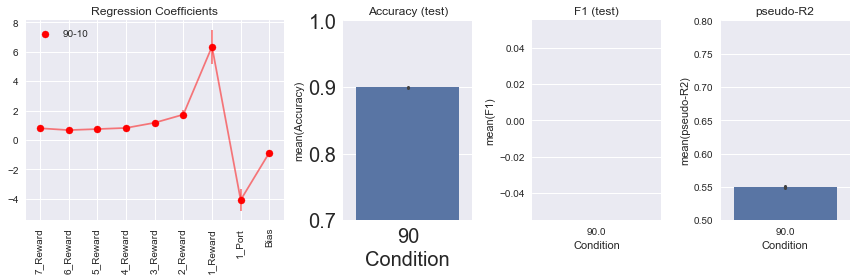

In [19]:
sns.set_style('darkgrid')
plt.figure(figsize=(12,4))
gs = gridspec.GridSpec(1,4,width_ratios=[2,1,1,1])

plt.subplot(gs[0])
plt.errorbar(np.arange(coefs.shape[1]-1),coefs[coefs['Condition'] == 90].iloc[:,1:].mean(),
             yerr= coefs[coefs['Condition'] == 90].iloc[:,1:].mean() / np.sqrt(np.sum(coefs['Condition'] == 90)),
             color='red',alpha=0.5)
#plt.errorbar(np.arange(coefs.shape[1]-1),coefs[coefs['Condition'] == 80].iloc[:,1:].mean(),
 #            yerr= coefs[coefs['Condition'] == 90].iloc[:,1:].mean() / np.sqrt(np.sum(coefs['Condition'] == 90)),
   #          color='green',alpha=0.5)
#plt.errorbar(np.arange(coefs.shape[1]-1),coefs[coefs['Condition'] == 70].iloc[:,1:].mean(),
 #            yerr= coefs[coefs['Condition'] == 90].iloc[:,1:].mean() / np.sqrt(np.sum(coefs['Condition'] == 90)),
  #           color='navy',alpha=0.5)

plt.scatter(np.arange(coefs.shape[1]-1),coefs[coefs['Condition'] == 90].iloc[:,1:].mean(),
            color='red',label='90-10',s=50)
#plt.scatter(np.arange(coefs.shape[1]-1),coefs[coefs['Condition'] == 80].iloc[:,1:].mean(),
 #           color='green',label='80-20',s=50)
#plt.scatter(np.arange(coefs.shape[1]-1),coefs[coefs['Condition'] == 70].iloc[:,1:].mean(),
 #           color='navy',label='70-30',s=50)

plt.legend(loc='upper left')
plt.xticks(np.arange(coefs.shape[1]),coefs.columns.values[1:],rotation='vertical')
plt.xlim(-0.5,8.5)
plt.title('Regression Coefficients')

plt.subplot(gs[1])
sns.barplot(x='Condition',y='Accuracy',data=stats)
plt.title('Accuracy (test)')
plt.xticks([0],['90'],fontsize=20)
plt.yticks([0.7,0.8,0.9,1.0],fontsize=20)
plt.xlabel('Condition',fontsize=20)
plt.ylim(0.7,1)

plt.subplot(gs[2])
sns.barplot(x='Condition',y='F1',data=stats)
plt.title('F1 (test)')



plt.subplot(gs[3])
sns.barplot(x='Condition',y='pseudo-R2',data=stats)
plt.title('pseudo-R2')
plt.ylim(0.5,0.8)

plt.tight_layout()

In [ ]:
stats

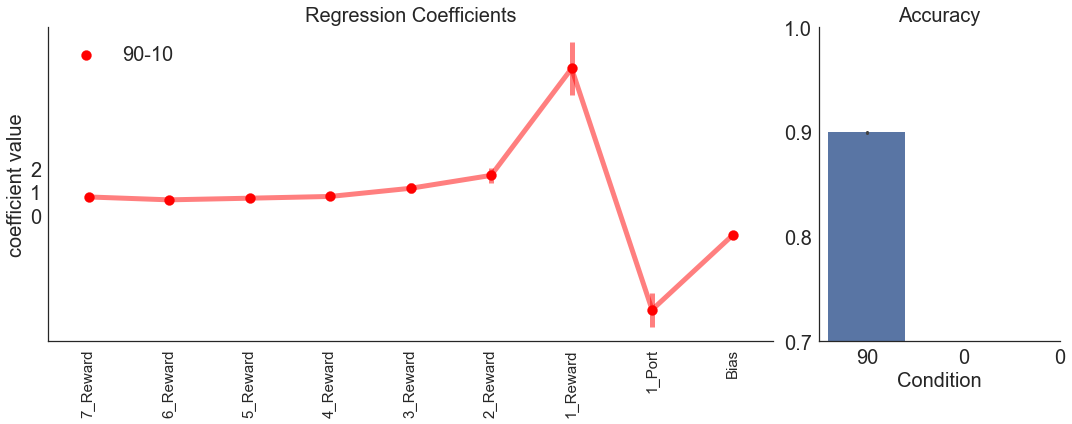

In [20]:
sns.set_style('white')
plt.figure(figsize=(15,6))
gs = gridspec.GridSpec(1,2,width_ratios=[3,1])

plt.subplot(gs[0])
plt.errorbar(np.arange(coefs.shape[1]-1),coefs[coefs['Condition'] == 90].iloc[:,1:].mean(),
             yerr= coefs[coefs['Condition'] == 90].iloc[:,1:].mean() / np.sqrt(np.sum(coefs['Condition'] == 90)),
             color='red',alpha=0.5,linewidth=5)
#plt.errorbar(np.arange(coefs.shape[1]-1),coefs[coefs['Condition'] == 80].iloc[:,1:].mean(),
 #            yerr= coefs[coefs['Condition'] == 90].iloc[:,1:].mean() / np.sqrt(np.sum(coefs['Condition'] == 90)),
  #           color='green',alpha=0.5,linewidth=5)
#plt.errorbar(np.arange(coefs.shape[1]-1),coefs[coefs['Condition'] == 70].iloc[:,1:].mean(),
 #            yerr= coefs[coefs['Condition'] == 90].iloc[:,1:].mean() / np.sqrt(np.sum(coefs['Condition'] == 90)),
  #           color='navy',alpha=0.5,linewidth=5)

plt.scatter(np.arange(coefs.shape[1]-1),coefs[coefs['Condition'] == 90].iloc[:,1:].mean(),
            color='red',label='90-10',s=100)
#plt.scatter(np.arange(coefs.shape[1]-1),coefs[coefs['Condition'] == 80].iloc[:,1:].mean(),
 #           color='green',label='80-20',s=100)
#plt.scatter(np.arange(coefs.shape[1]-1),coefs[coefs['Condition'] == 70].iloc[:,1:].mean(),
 #           color='navy',label='70-30',s=100)

plt.legend(loc='upper left',fontsize=20)
plt.xticks(np.arange(coefs.shape[1]),coefs.columns.values[1:],rotation='vertical',fontsize=15)
plt.xlabel('')
plt.yticks([0,1,2],fontsize=20)
plt.ylabel('coefficient value',fontsize=20)
plt.xlim(-0.5,8.5)
plt.title('Regression Coefficients',fontsize=20)

plt.subplot(gs[1])
sns.barplot(x='Condition',y='Accuracy',data=stats)
plt.title('Accuracy',fontsize=20)
plt.xticks([0,1,2],['90','0','0'],fontsize=20)
plt.yticks([0.7,0.8,0.9,1.0],fontsize=20)
plt.xlabel('Condition',fontsize=20)
plt.ylabel('')
plt.ylim(0.7,1)

plt.tight_layout()
sns.despine()

## END

## Test number of parameters / model flexibility vs BIC

In [ ]:
stats.head(2)

In [ ]:
d = data_80.copy()
stats = pd.DataFrame(columns=['Accuracy','BIC','negative loglikelihood','pseudo-R2','No. parameters','F1'])

for i,n in enumerate(np.arange(10,0,-1)):
    
    for j in enumerate(range(30)):
        model_curr,stats_curr,coefs_curr = logreg_and_eval(d,num_rewards=n)
        models.append(models)
        stats_curr['No. parameters'] = n
        stats = stats.append(stats_curr)

In [ ]:
plt.figure(figsize=(10,4))
sns.factorplot(x='No. parameters',y='BIC',data=stats,color='black')
plt.title('BIC vs model flexibility')

In [ ]:
BIC = np.zeros((10,10))
F1 = np.zeros((10,10))
R2 = np.zeros((10,10))
acc = np.zeros((10,10))

for i in range(10):
    for j in range(10):
        if not ((j==0) & (i==0)):
            model_curr,stats_curr,coefs_curr = logreg_and_eval_withports(d,num_rewards=i,num_ports=j)
            BIC[i,j] = stats_curr['BIC'].values
            F1[i,j] = stats_curr['F1'].values
            R2[i,j] = stats_curr['pseudo-R2'].values
            acc[i,j] = stats_curr['Accuracy'].values

In [ ]:
plt.figure(figsize=(20,5))
plt.suptitle('Model behavior vs # of rewards and decisions included',x=0.5,y=1.05,fontsize=20)

plt.subplot(141)
sns.heatmap(BIC,vmin=15000,vmax=25000)
plt.xlabel('# previous decisions in model',fontsize=15)
plt.ylabel('# previous reward outcomes in model',fontsize=15)
plt.title('BIC',fontsize=15)

plt.subplot(142)
sns.heatmap(F1)
plt.xlabel('# previous decisions in model',fontsize=15)
plt.ylabel('# previous reward outcomes in model',fontsize=15)
plt.title('F1',fontsize=15)

plt.subplot(143)
sns.heatmap(R2,vmin=0.5)
plt.xlabel('# previous decisions in model',fontsize=15)
plt.ylabel('# previous reward outcomes in model',fontsize=15)
plt.title('R2')

plt.subplot(144)
sns.heatmap(acc,vmin=0.8)
plt.xlabel('# previous decisions in model',fontsize=15)
plt.ylabel('# previous reward outcomes in model',fontsize=15)
plt.title('Accuracy')

plt.tight_layout()

# Training / testing on different conditions

### 1. Train on 90-10, test on 80-20 and 70-30

In [ ]:
for i,d in enumerate([data_90,data_80,data_70]):
    
    if i == 0:
        model,stats,coefs = logreg_and_eval(d)
    else:
        model,stats_curr,coefs_curr = logreg_and_eval(data_90,test_data = d)
        
        stats = stats.append(stats_curr)
        coefs = coefs.append(coefs_curr)

stats_90 = stats.drop(['BIC','negative loglikelihood','pseudo-R2'],axis=1)

In [ ]:
stats_90['Testing Condition'] = [90,80,70]
stats_90

So this is interesting - accuracy stays pretty much the same across conditions, but F1 goes way down. And if we take a look at the confusion tables above, we can see it is because the accuracy on the switches went down (and accuracy on stays went up. 

### 2. Train on 80-20

In [ ]:
for i,d in enumerate([data_80,data_90,data_70]):
    
    if i == 0:
        model,stats,coefs = logreg_and_eval(d)
    else:
        model,stats_curr,coefs_curr = logreg_and_eval(data_80,test_data = d)
        
        stats = stats.append(stats_curr)
        coefs = coefs.append(coefs_curr)

stats_80 = stats.drop(['BIC','negative loglikelihood','pseudo-R2'],axis=1)

stats_80['Testing Condition'] = [80,90,70]
stats_80

### 3. Train on 70-30

In [ ]:
for i,d in enumerate([data_70,data_80,data_90]):
    
    if i == 0:
        model,stats,coefs = logreg_and_eval(d)
    else:
        model,stats_curr,coefs_curr = logreg_and_eval(data_70,test_data = d)
        
        stats = stats.append(stats_curr)
        coefs = coefs.append(coefs_curr)

stats_70 = stats.drop(['BIC','negative loglikelihood','pseudo-R2'],axis=1)

stats_70['Testing Condition'] = [70,80,90]
stats_70

In [ ]:
f1s = np.vstack((stats_90['F1'].values,
               stats_80['F1'].values[[1,0,2]],
               stats_70['F1'].values[[2,1,0]]))
sns.heatmap(f1s,vmin=0,vmax=0.4)
plt.xticks([0.5,1.5,2.5],['90','80','70'])
plt.yticks([0.5,1.5,2.5],['70','80','90'])
plt.ylabel('Testing Condition')
plt.xlabel('Training Condition')
plt.title('F1 scores when trained & tested on different conditions')

So if this is right, it means that the rules are different - what predicts a switch in 90-10 does not predict a switch in 80-20. But since most of the trials follow the last one, the accuracy doesn't drop very much. So it appears to be working fine, even though it is not. 

Can the difference be explained in the small differences in beta coefficient values? It must be ... what else is there? They seem similar enough that I'm surprised it makes such a difference. 

Let's go on to train and test on separate mice:

# Train/test on separate mice

First let's take a quick look at the mice's performances - specifically just at p(choose high P port):

In [ ]:
data_90.insert(0,'Condition',0.9)
data_80.insert(0,'Condition',0.8)
data_70.insert(0,'Condition',0.7)

In [ ]:
all_data = data_90.append(data_80)
all_data = all_data.append(data_70)
all_data.shape

In [ ]:
sns.factorplot(x='Condition',y='Higher p port',hue='Mouse ID',data = all_data,legend=False,size=5,aspect=1.7)
plt.legend(bbox_to_anchor=(1.2,1))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Condition',fontsize=20)
plt.ylabel('rate higher prob port chosen',fontsize=20)
plt.title('Average p(choose better port) for each mouse across conditions',fontsize=20,x=0.5,y=1.1)

Okay, so based on this. Let's start with 80-20, and do a few different comparisons. 

1. Start by training with harry, and testing on all the others. 
2. Then try training on volde, testing on all others. 
3. Finally train on someone in the middle - like Tom or q45, and test on others

In [ ]:
'''
Loop through mice
'''
mice = np.unique(data_80['Mouse ID'].values)

stats = pd.DataFrame(columns=['Accuracy','F1','Training Mouse','Testing Mouse'])
test_mice = []
train_mice = []

for mouse_train in mice:

    d_train = data_80[data_80['Mouse ID'] == mouse_train].copy()

    for i,mouse_test in enumerate(mice):
        d_test = data_80[data_80['Mouse ID'] == mouse_test].copy()

        if i == 0:
            model,stats_curr,coefs = logreg_and_eval(d_train,test_data = d_test)
            stats_curr = stats_curr.drop(['BIC','negative loglikelihood','pseudo-R2'],axis=1)
            stats = stats.append(stats_curr)
        else:
            model,stats_curr,coefs_curr = logreg_and_eval(d_train,test_data = d_test)
            stats_curr = stats_curr.drop(['BIC','negative loglikelihood','pseudo-R2'],axis=1)
            stats= stats.append(stats_curr)
            coefs = coefs.append(coefs_curr)

        test_mice.append(mouse_test)
        train_mice.append(mouse_train)

stats['Testing Mouse'] = test_mice
stats['Training Mouse'] = train_mice
acc_matrix = np.reshape(stats['Accuracy'].values,(len(mice),-1)).T
F1_matrix = np.reshape(stats['F1'].values,(len(mice),-1)).T

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.heatmap(acc_matrix)
plt.xticks(np.arange(11)+0.5,mice,rotation='vertical')
plt.yticks(np.arange(11)+0.5,mice[::-1],rotation='horizontal')
plt.xlabel('Training Mouse')
plt.ylabel('Testing Mouse')
plt.title('Accuracy')

plt.subplot(122)
sns.heatmap(F1_matrix)
plt.xticks(np.arange(11)+0.5,mice,rotation='vertical')
plt.yticks(np.arange(11)+0.5,mice[::-1],rotation='horizontal')
plt.xlabel('Training Mouse')
plt.ylabel('Testing Mouse')
plt.title('F1')

In [ ]:
data_80.head(2)

In [ ]:
u_switch = np.zeros(len(mice))
u_acc = np.zeros(len(mice))

for i,mouse in enumerate(mice):
    u_switch[i] = data_80[data_80['Mouse ID']== mouse]['Switch'].mean()
    u_acc[i] = data_80[data_80['Mouse ID']== mouse]['Higher p port'].mean()

In [ ]:
colors = sns.color_palette('hls',n_colors=len(mice))
plt.figure(figsize=(12,5))
plt.suptitle('Higher switch rates anti-correlate with accuracy on test mice',fontsize=20,x=0.5,y=1.1)
plt.subplot(121)
for i,mouse in enumerate(mice):
    plt.scatter(u_switch[i],acc_matrix[i,:].mean(),label=mouse,c=colors[i],s=50)
#plt.legend(bbox_to_anchor=(1.3,1))
plt.xlabel('mean switch rate')
plt.ylabel('mean accuracy when used as test mouse')
plt.ylim(0.75,1)
plt.xlim(0,0.22)
plt.title('Testing accuracy vs mean switch rate')


plt.subplot(122)
for i,mouse in enumerate(mice):
    plt.scatter(u_switch[i],acc_matrix[:,i].mean(),label=mouse,c=colors[i],s=50)
plt.legend(bbox_to_anchor=(1.3,1))
plt.xlabel('mean switch rate')
plt.ylabel('mean accuracy when used as train mouse')
plt.ylim(0.75,1)
plt.xlim(0,0.22)
plt.title('Training accuracy vs mean switch rate')

plt.tight_layout()

In [ ]:
colors = sns.color_palette('hls',n_colors=len(mice))
plt.figure(figsize=(12,5))
plt.suptitle('Higher switch rates correlate with F1 score on test mice',fontsize=20,x=0.5,y=1.1)
plt.subplot(121)
for i,mouse in enumerate(mice):
    plt.scatter(u_switch[i],F1_matrix[i,:].mean(),label=mouse,c=colors[i],s=50)
#plt.legend(bbox_to_anchor=(1.3,1))
plt.xlabel('mean switch rate')
plt.ylabel('mean F1 when used as test mouse')
#plt.ylim(0.75,1)
#plt.xlim(0,0.22)
plt.title('Testing F1 vs mean switch rate')


plt.subplot(122)
for i,mouse in enumerate(mice):
    plt.scatter(u_switch[i],F1_matrix[:,i].mean(),label=mouse,c=colors[i],s=50)
plt.legend(bbox_to_anchor=(1.3,1))
plt.xlabel('mean switch rate')
plt.ylabel('mean F1 when used as train mouse')
#plt.ylim(0.75,1)
#plt.xlim(0,0.22)
plt.title('Training F1 vs mean switch rate')

plt.tight_layout()

In [ ]:
colors = sns.color_palette('hls',n_colors=len(mice))
plt.figure(figsize=(12,5))
plt.suptitle('Better behavior correlates with accuracy score on test mice',fontsize=20,x=0.5,y=1.1)
plt.subplot(121)
for i,mouse in enumerate(mice):
    plt.scatter(u_acc[i],acc_matrix[i,:].mean(),label=mouse,c=colors[i],s=50)
#plt.legend(bbox_to_anchor=(1.3,1))
plt.xlabel('mean p(high p port)')
plt.ylabel('mean acc when used as test mouse')
#plt.ylim(0.75,1)
#plt.xlim(0,0.22)
plt.title('Testing Acc vs mean p(high p port)')


plt.subplot(122)
for i,mouse in enumerate(mice):
    plt.scatter(u_acc[i],acc_matrix[:,i].mean(),label=mouse,c=colors[i],s=50)
plt.legend(bbox_to_anchor=(1.3,1))
plt.xlabel('mean p(high p port)')
plt.ylabel('mean acc when used as train mouse')
#plt.ylim(0.75,1)
#plt.xlim(0,0.22)
plt.title('Training acc vs mean p(high p port)')

plt.tight_layout()

In [ ]:
colors = sns.color_palette('hls',n_colors=len(mice))
plt.figure(figsize=(12,5))
plt.suptitle('p(high p port) vs F1 score',fontsize=20,x=0.5,y=1.1)
plt.subplot(121)
for i,mouse in enumerate(mice):
    plt.scatter(u_acc[i],F1_matrix[i,:].mean(),label=mouse,c=colors[i],s=50)
#plt.legend(bbox_to_anchor=(1.3,1))
plt.xlabel('p(high p port)')
plt.ylabel('mean F1 when used as test mouse')
#plt.ylim(0.75,1)
#plt.xlim(0,0.22)
plt.title('Testing F1 vs mean switch rate')


plt.subplot(122)
for i,mouse in enumerate(mice):
    plt.scatter(u_acc[i],F1_matrix[:,i].mean(),label=mouse,c=colors[i],s=50)
plt.legend(bbox_to_anchor=(1.3,1))
plt.xlabel('p(high p port)')
plt.ylabel('mean F1 when used as train mouse')
#plt.ylim(0.75,1)
#plt.xlim(0,0.22)
plt.title('Training F1 vs mean switch rate')

plt.tight_layout()

# Trying interaction terms

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
poly = PolynomialFeatures(degree=2,interaction_only=True,include_bias=True)

In [ ]:
def logreg_and_eval_withports_and_interactions(data,num_rewards=10,num_ports=1,test_data=False):
    '''
    Perform Logistic Regression on a pandas dataframe of trials (from feature matrix) with interactions
    
    Inputs:
        - data: pandas dataframe of trials (from feature matrix)
    Outputs:
        - logreg: trained logistic regression model (from sklearn)
        - stats:  pandas dataframe with F1, pseudo-R2, and BIC scores from model
        - coeffs: beta coefficients from logreg
    
    '''
    
    from statsmodels.discrete.discrete_model import Logit
    
    port_features = []
    reward_features = []

    #change right port to -1 instead of 0
    for col in data:
        if '_Port' in col:
            data.loc[data[col] == 0,col] = -1
            port_features.append(col)
        elif '_Reward' in col:
            reward_features.append(col)

    #create new feature matrix
    d = data.copy()
    for i in range(len(port_features)):
        d[reward_features[i]] = d[reward_features[i]].values*d[port_features[i]].values
    
    
    #determine the features
    features = reward_features.copy()
    if num_rewards == 0:
        features = port_features[-1*num_ports:]
    elif num_ports == 0:
        features = features[-1*num_rewards:] #only take the num of rewards specificied in the function
    else:
        features = features[-1*num_rewards:]
        features = np.append(features,port_features[-1*num_ports:])
    
    print(features)
    features = np.append(features,'Decision') #finally append the decision so we can take it to predict later
    
    
    
    #final version of data
    d = d[features].copy() #this now just has the features we want and the decision we want to predict
    
    #do the same thing for the test data if it exists!
    if test_data is not False:
        for col in test_data:
            if '_Port' in col:
                test_data.loc[test_data[col] == 0,col] = -1

        #create new feature matrix
        data_test_new = test_data.copy()
        for i in range(len(port_features)):
            data_test_new[reward_features[i]] = test_data[reward_features[i]].values*test_data[port_features[i]].values
        
        d_test = data_test_new[features].copy()
    
    
        #set training and testing sets now
        x_train = d.iloc[:,:-1].values
        y_train = d.iloc[:,-1].values
        x_test = d_test.iloc[:,:-1].values
        y_test = d_test.iloc[:,-1].values
        
        prev_port_test = test_data['1_Port'].values
        prev_port_test[prev_port_test==-1] = 0
    
    #if there is no test data, then split up the data into training and testing
    else:
        #extract features and decisions
        x = d.iloc[:,:-1].values
        y = d.iloc[:,-1].values

        #split into training and testing
        n_trials = x.shape[0]
        shuf_inds = np.random.permutation(n_trials)
        split_ind = int(n_trials*0.7)

        x_train = x[shuf_inds[:split_ind],:]
        y_train = y[shuf_inds[:split_ind]]

        x_test = x[shuf_inds[split_ind:],:]
        y_test = y[shuf_inds[split_ind:]]
        
        #extract previous port decision for test set
        #these will be used to calculate switches on the test predictions
        prev_port_test = data['1_Port'].values[shuf_inds[split_ind:]]
        prev_port_test[prev_port_test==-1] = 0
    
    '''
    Modeling
    '''
    
    #create interaction terms
    poly = PolynomialFeatures(degree=5,interaction_only=True,include_bias=True)
    x_train = poly.fit_transform(x_train)
    x_test = poly.fit_transform(x_test)
    print('x_train shape: %.0f' % x_train.shape[1])
    
    
    #fit logistic regression
    logreg = sklearn.linear_model.LogisticRegressionCV()
    logreg.fit(x_train,y_train)
    
    #predict on testing set
    y_predict = logreg.predict(x_test)
    y_predict_proba = logreg.predict_proba(x_test)
    
    #model accuracy
    score = logreg.score(x_test,y_test)
    
    #calculating pseudo-R2 and BIC from statsmodel OLS
    model = Logit(y_train,x_train)
    rslt  = model.fit()

    #switches
    y_test_switch = np.abs(y_test - prev_port_test)
    y_predict_switch = np.abs(y_predict - prev_port_test)
    acc_pos,acc_neg,F1=sf.score_both_and_confuse(y_predict_switch,y_test_switch,confusion=False,disp=True)
    
    #extract coefficients
    coefs = logreg.coef_ #retrieve coefs
    coefs = np.append(coefs[0],logreg.intercept_) #add bias coef
    
    #create stats database to return
    d_ = {'pseudo-R2':rslt.prsquared,'stay':acc_pos,'switch':acc_neg,'Accuracy':score,'BIC':rslt.bic,'negative loglikelihood':-1*rslt.llf}
    stats = pd.DataFrame(data=d_,index=[0])
    features = features[:-1]
    features = np.append(features,'Bias')
    
    #coefs = pd.DataFrame(data=coefs.reshape(1,-1),columns=poly.get_feature_names())
    return logreg,stats

In [ ]:
model,stats_curr = logreg_and_eval_withports_and_interactions(data_80,num_rewards = 5)

In [ ]:
model.coef_.shape[1]

In [ ]:
plt.scatter(np.arange(model.coef_.shape[1]),model.coef_)